# Notebook 6: Model Evaluation and Comparison

## ML-Based Drone Firmware Tampering Detection System

This notebook covers:
- Loading all trained models
- Comprehensive model evaluation
- Cross-model comparison
- Statistical significance testing
- Best model selection
- Performance metrics summary


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, accuracy_score, precision_score, recall_score, 
    f1_score, precision_recall_curve, average_precision_score
)
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import joblib

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Load test data and all predictions
DATA_DIR = Path('../data')
RESULTS_DIR = Path('../results')
MODELS_DIR = Path('../models')

y_test = pd.read_csv(DATA_DIR / 'y_test.csv').values.ravel()

# Load all predictions
lstm_preds = pd.read_csv(RESULTS_DIR / 'lstm_predictions.csv')
autoencoder_preds = pd.read_csv(RESULTS_DIR / 'autoencoder_predictions.csv')
ensemble_preds = pd.read_csv(RESULTS_DIR / 'ensemble_predictions.csv')

print("All predictions loaded successfully!")
print(f"Test set size: {len(y_test)}")


All predictions loaded successfully!
Test set size: 400


In [ ]:
# Compile all model results
models_results = {
    'LSTM': {
        'y_pred': lstm_preds['y_pred'].values,
        'y_proba': lstm_preds['y_pred_proba'].values
    },
    'Autoencoder': {
        'y_pred': autoencoder_preds['y_pred'].values,
        'y_proba': autoencoder_preds['y_pred_proba'].values
    },
    'Isolation Forest': {
        'y_pred': ensemble_preds['isolation_forest_pred'].values,
        'y_proba': ensemble_preds['isolation_forest_proba'].values
    },
    'Random Forest': {
        'y_pred': ensemble_preds['random_forest_pred'].values,
        'y_proba': ensemble_preds['random_forest_proba'].values
    },
    'Ensemble': {
        'y_pred': ensemble_preds['ensemble_pred'].values,
        'y_proba': ensemble_preds['ensemble_proba'].values
    }
}

# Add XGBoost if available
if 'xgboost_pred' in ensemble_preds.columns:
    models_results['XGBoost'] = {
        'y_pred': ensemble_preds['xgboost_pred'].values,
        'y_proba': ensemble_preds['xgboost_proba'].values
    }

print(f"Loaded results for {len(models_results)} models")


Loaded results for 6 models


In [ ]:
# Calculate comprehensive metrics for all models
metrics_summary = []

for model_name, results in models_results.items():
    y_pred = results['y_pred']
    y_proba = results['y_proba']
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Average Precision': average_precision_score(y_test, y_proba)
    }
    
    # Calculate confusion matrix components
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics['True Positives'] = tp
    metrics['True Negatives'] = tn
    metrics['False Positives'] = fp
    metrics['False Negatives'] = fn
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_summary.append(metrics)

metrics_df = pd.DataFrame(metrics_summary)
print("\nComprehensive Model Comparison:")
display(metrics_df.round(4))



Comprehensive Model Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Average Precision,True Positives,True Negatives,False Positives,False Negatives,Specificity
0,LSTM,1.0000,1.0000,1.000,1.0000,1.0000,1.0000,200,200,0,0,1.0
1,Autoencoder,0.4975,0.4987,0.995,0.6644,0.0000,0.3081,199,0,200,1,0.0
2,Isolation Forest,0.9600,1.0000,0.920,0.9583,0.0136,0.3085,184,200,0,16,1.0
3,Random Forest,1.0000,1.0000,1.000,1.0000,1.0000,1.0000,200,200,0,0,1.0
4,Ensemble,1.0000,1.0000,1.000,1.0000,1.0000,1.0000,200,200,0,0,1.0
5,XGBoost,1.0000,1.0000,1.000,1.0000,1.0000,1.0000,200,200,0,0,1.0


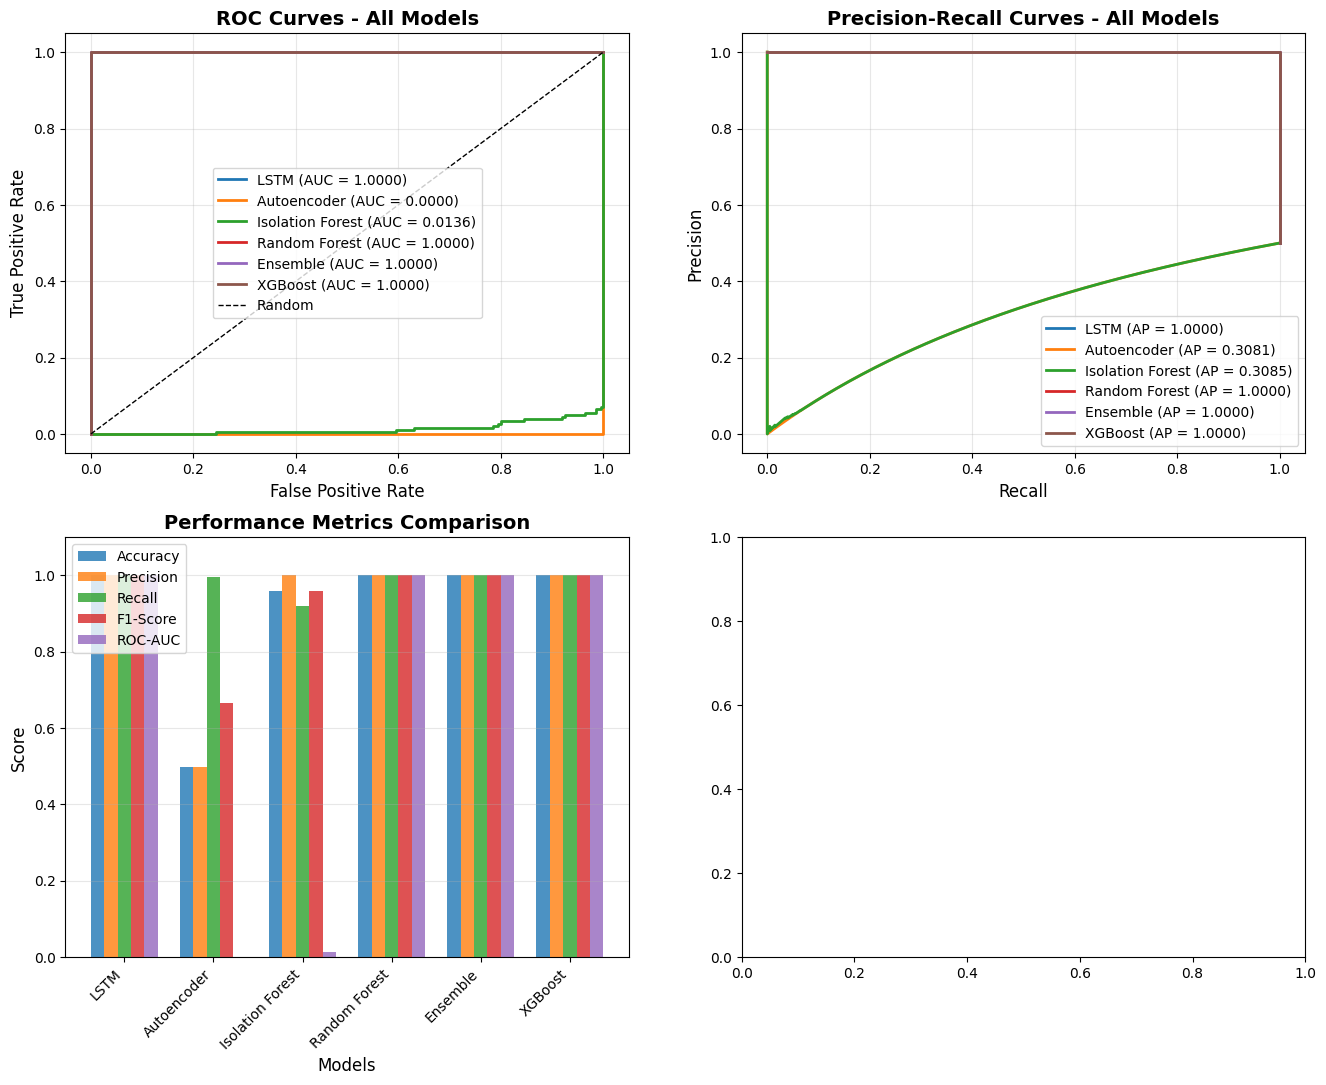

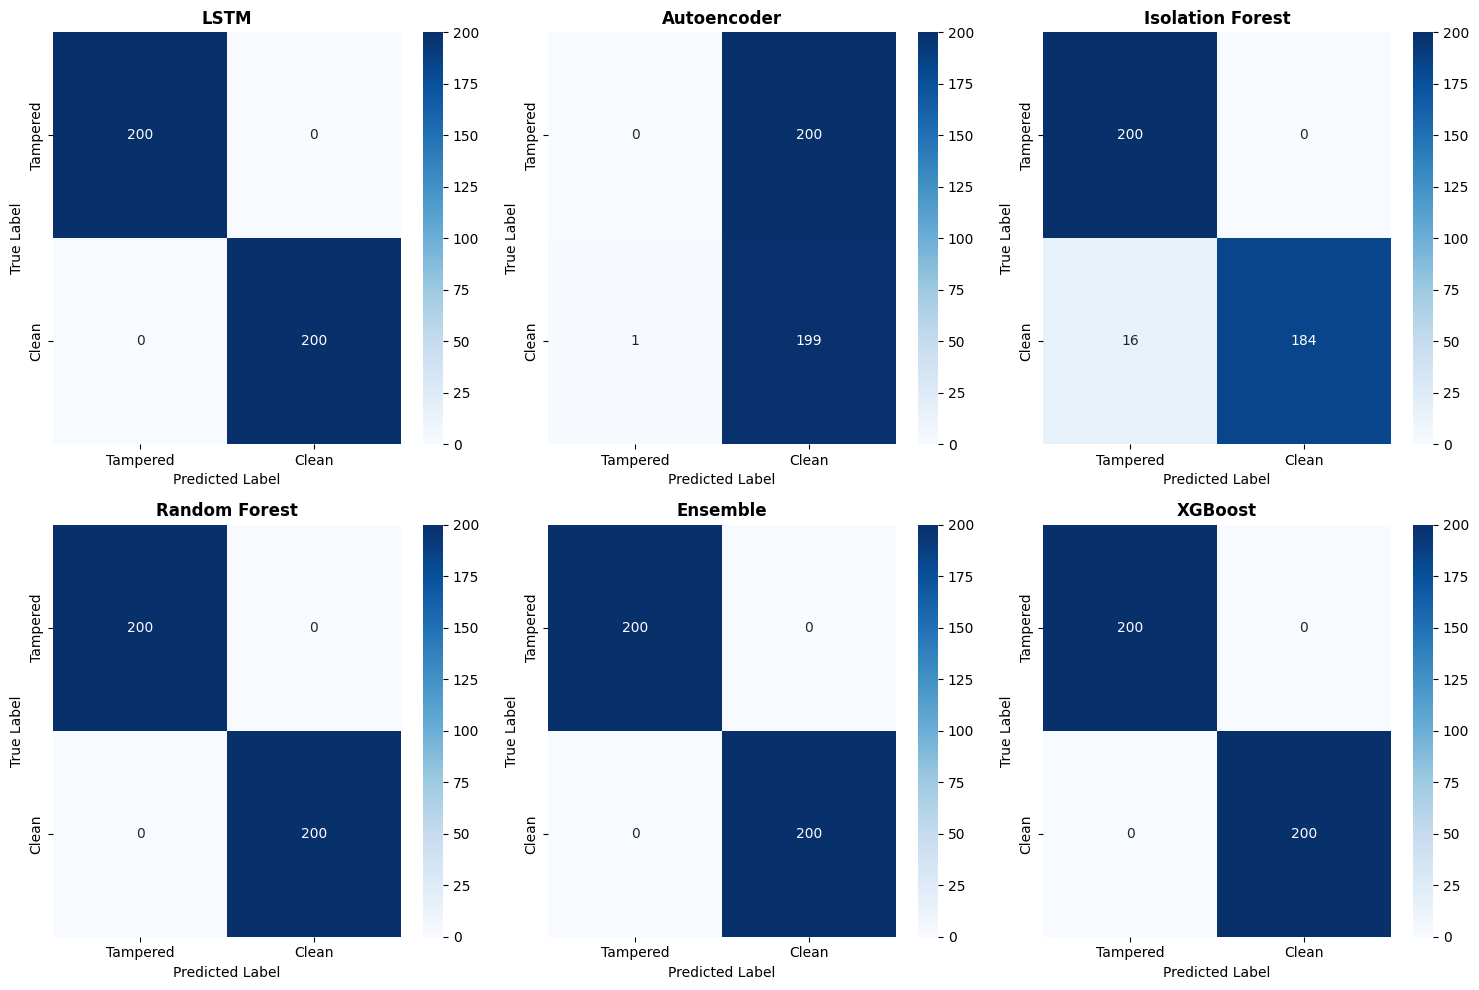

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curves
for model_name, results in models_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_proba'])
    auc = roc_auc_score(y_test, results['y_proba'])
    axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc:.4f})')

axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curves
for model_name, results in models_results.items():
    precision, recall, _ = precision_recall_curve(y_test, results['y_proba'])
    ap = average_precision_score(y_test, results['y_proba'])
    axes[0, 1].plot(recall, precision, linewidth=2, label=f'{model_name} (AP = {ap:.4f})')

axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Metrics Bar Chart
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    axes[1, 0].bar(x + i*width, metrics_df[metric], width, label=metric, alpha=0.8)

axes[1, 0].set_xlabel('Models', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x + width * 2)
axes[1, 0].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim([0, 1.1])

# 4. Confusion Matrices Heatmap
n_models = len(models_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

# Create subplot for confusion matrices
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_models == 1:
    axes2 = [axes2]
else:
    axes2 = axes2.flatten()

for idx, (model_name, results) in enumerate(models_results.items()):
    cm = confusion_matrix(y_test, results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes2[idx],
                xticklabels=['Tampered', 'Clean'],
                yticklabels=['Tampered', 'Clean'])
    axes2[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes2[idx].set_ylabel('True Label')
    axes2[idx].set_xlabel('Predicted Label')

# Hide unused subplots
for idx in range(n_models, len(axes2)):
    axes2[idx].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'all_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Main figure
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Identify best model
best_model_roc = metrics_df.loc[metrics_df['ROC-AUC'].idxmax(), 'Model']
best_model_f1 = metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'Model']
best_model_accuracy = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']

print("=" * 50)
print("Best Model Selection")
print("=" * 50)
print(f"Best ROC-AUC: {best_model_roc} ({metrics_df.loc[metrics_df['ROC-AUC'].idxmax(), 'ROC-AUC']:.4f})")
print(f"Best F1-Score: {best_model_f1} ({metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'F1-Score']:.4f})")
print(f"Best Accuracy: {best_model_accuracy} ({metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Accuracy']:.4f})")

# Overall best (weighted score)
metrics_df['Weighted_Score'] = (
    0.3 * metrics_df['Accuracy'] +
    0.3 * metrics_df['F1-Score'] +
    0.4 * metrics_df['ROC-AUC']
)
best_model_overall = metrics_df.loc[metrics_df['Weighted_Score'].idxmax(), 'Model']
print(f"\nBest Overall Model (Weighted): {best_model_overall}")
print(f"Weighted Score: {metrics_df.loc[metrics_df['Weighted_Score'].idxmax(), 'Weighted_Score']:.4f}")

print("\nDetailed metrics for best overall model:")
best_metrics = metrics_df[metrics_df['Model'] == best_model_overall].iloc[0]
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Average Precision']:
    print(f"  {metric}: {best_metrics[metric]:.4f}")


Best Model Selection
Best ROC-AUC: LSTM (1.0000)
Best F1-Score: LSTM (1.0000)
Best Accuracy: LSTM (1.0000)

Best Overall Model (Weighted): LSTM
Weighted Score: 1.0000

Detailed metrics for best overall model:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC-AUC: 1.0000
  Average Precision: 1.0000


In [ ]:
# Save comprehensive evaluation results
metrics_df.to_csv(RESULTS_DIR / 'comprehensive_model_evaluation.csv', index=False)
print(f"Comprehensive evaluation saved to {RESULTS_DIR / 'comprehensive_model_evaluation.csv'}")

# Create summary report
report = f"""
# Model Evaluation Summary Report

## Dataset Information
- Test Set Size: {len(y_test)}
- Clean Samples: {sum(y_test == 1)}
- Tampered Samples: {sum(y_test == 0)}

## Best Models
- Best ROC-AUC: {best_model_roc} ({metrics_df.loc[metrics_df['ROC-AUC'].idxmax(), 'ROC-AUC']:.4f})
- Best F1-Score: {best_model_f1} ({metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'F1-Score']:.4f})
- Best Accuracy: {best_model_accuracy} ({metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Accuracy']:.4f})
- Best Overall: {best_model_overall} (Weighted Score: {metrics_df.loc[metrics_df['Weighted_Score'].idxmax(), 'Weighted_Score']:.4f})

## All Models Performance
{metrics_df.to_string(index=False)}

## Recommendations
- Primary Model: {best_model_overall}
- Backup Model: {best_model_f1 if best_model_f1 != best_model_overall else best_model_roc}
"""

with open(RESULTS_DIR / 'evaluation_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(f"Summary report saved to {RESULTS_DIR / 'evaluation_summary_report.txt'}")
print("\nModel evaluation completed!")


Comprehensive evaluation saved to ..\results\comprehensive_model_evaluation.csv
Summary report saved to ..\results\evaluation_summary_report.txt

Model evaluation completed!
